This script correct the drift of zostoga by removing the linear trend in PiControl, assuming the drift is not sensitive to the external forcing (Hobbs et al. 2015)

In [44]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from scipy.stats import linregress

In [ ]:
model_list = ['GISS-E2-R','IPSL-CM5A-LR','HadGEM2-ES', 'MPI-ESM-LR','bcc-csm1-1']
Dirt = '/projects/kopp/jy519/data/CMIP5/monthly'

In [40]:
# load zostoga
zostoga_list = []
year_list = []
for i, model in enumerate(model_list):
    f1 = sorted(glob('{:}/{:}/zostoga_Omon_{:}_piControl_r1i1p1_*.nc'.format(Dirt, model.lower(), model)))
    if len(f1)==1:
        ds1 = xr.open_dataset(f1[0])
        zostoga = ds1.zostoga
    else:
        zoslist = []
        for j in range(len(f1)):
            ds1 = xr.open_dataset(f1[j])
            zos1 = ds1.zostoga
            zoslist.append(zos1)
        zostoga = xr.concat(zoslist, dim='time')
    # compute the annual mean
    try:
        yr_temp1 = zostoga.time.dt.year
        years1 = np.arange(yr_temp1.min(), yr_temp1.max())
        if zostoga.time.dt.month[0]==12:
            years1=years1[1:]
        zostoga_am = np.zeros([len(years1)])
        for j, year in enumerate(years1):
            if model=='bcc-csm1-1':
                zostoga_am[j] = zostoga.sel(time=str(year).zfill(4)).mean(dim='time')
            else:
                zostoga_am[j] = zostoga.sel(time=str(year)).mean(dim='time')
    except TypeError:
        years1 = range(zostoga.time[0].dt.year, zostoga.time[-1].dt.year+1)
        zostoga_am = np.reshape(zostoga.values,[len(years1),12]).mean(axis=1)
    zostoga_list.append(zostoga_am)
    year_list.append(years1)

/home/jy519/anaconda2/lib/python2.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


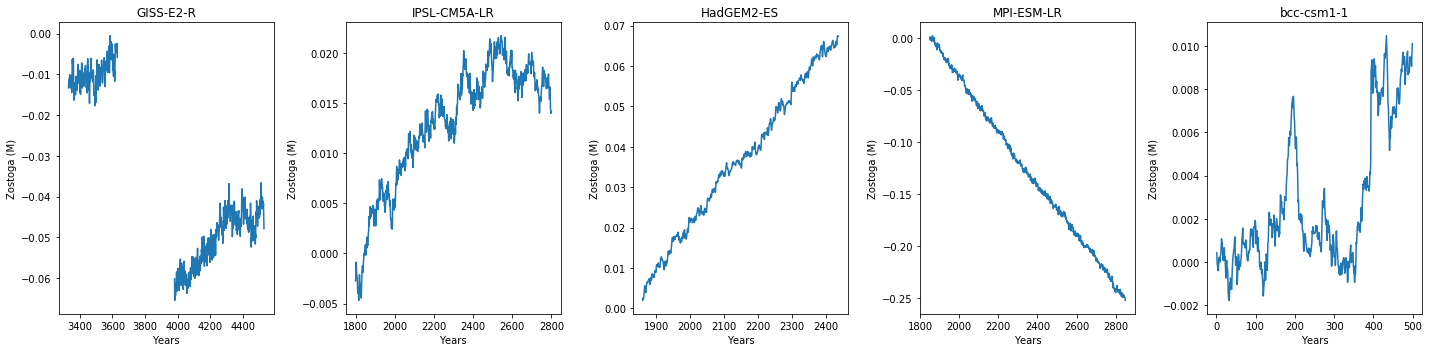

In [43]:
fig, axes = plt.subplots(1,5, figsize=(20,5),tight_layout=True)
for i, model in enumerate(model_list):
    draw = zostoga_list[i]
    yr = year_list[i]
    axes[i].plot(yr, draw)
    axes[i].set_title(model)
    axes[i].set_xlabel('Years')
    axes[i].set_ylabel('Zostoga (M)')

## Compute linear trend

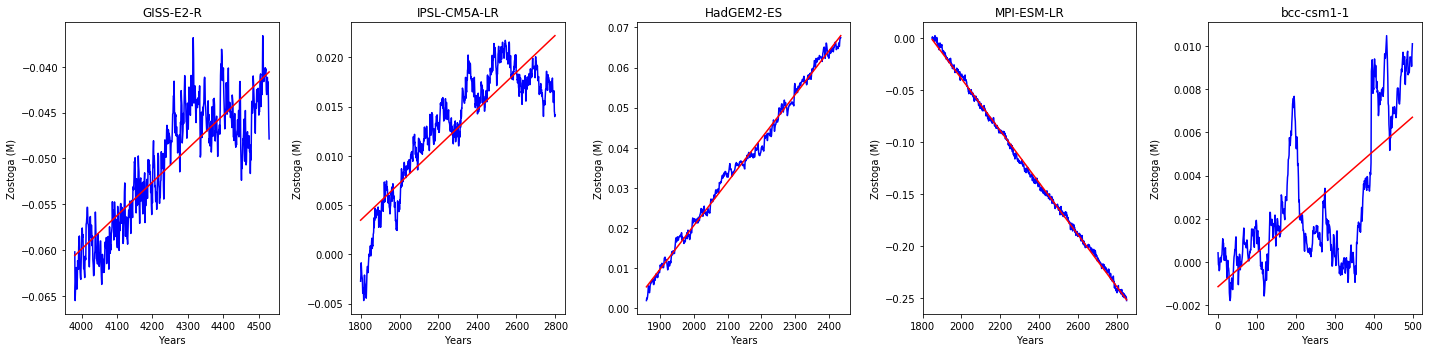

In [55]:
linregress_results = []
fig, axes = plt.subplots(1,5, figsize=(20,5),tight_layout=True)
for i, model in enumerate(model_list):    
    if model == 'GISS-E2-R':
        zostoga = zostoga_list[i][-549:]
        years = year_list[i][-549:]
    else:
        zostoga = zostoga_list[i]
        years = year_list[i]
    rs = linregress(years, zostoga)
    linregress_results.append(rs)
    slope = rs.slope
    intc = rs.intercept
    predict = slope*np.array(years)+intc
    axes[i].plot(years,zostoga,'b')
    axes[i].plot(years,predict,'r')
    axes[i].set_title(model)
    axes[i].set_xlabel('Years')
    axes[i].set_ylabel('Zostoga (M)')
    

## Remove linear trend from historical and RCP experiment

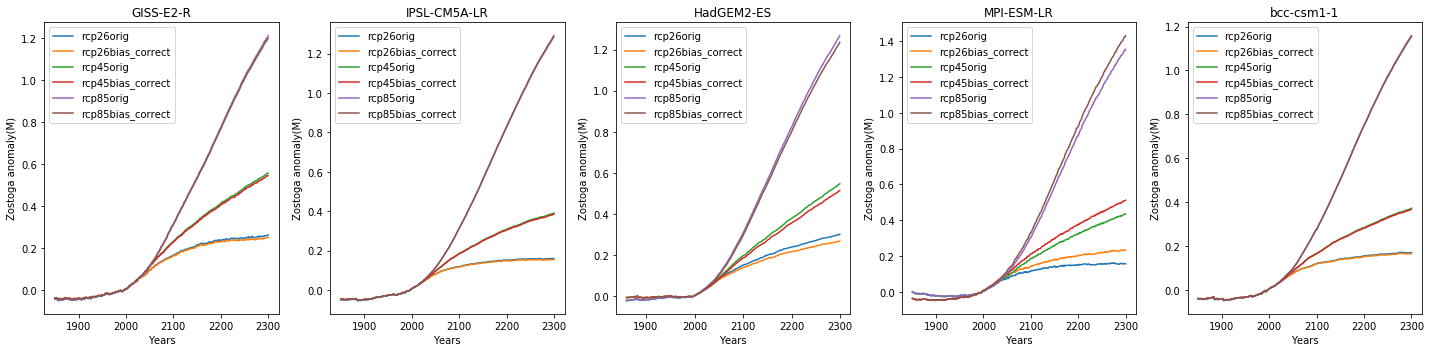

In [77]:
zostoga_dc = []
fig, axes = plt.subplots(1,5, figsize=(20,5),tight_layout=True)
for m,model in enumerate(model_list):
    slope = linregress_results[m].slope
    intc = linregress_results[m].intercept
    # historical
    f = sorted(glob('/projects/kopp/jy519/data/CMIP5/monthly/{:}/zostoga_Omon_{:}_historical_r1i1p1_*.nc'.format(model.lower(), model)))[0]
    ds = xr.open_dataset(f)
    zostogah = ds.zostoga
    # compute the annual mean
    yr_temp1 = ds.time.dt.year
    years1 = np.arange(yr_temp1.min(), 2006)
    if zostogah.time.dt.month[0]==12:
        years1=years1[1:]
    zostogah_am = np.zeros(len(years1))
    for i, year in enumerate(years1):
        zostogah_am[i] = zostogah.sel(time=str(year)).mean()
    zostogah_bl = zostogah_am[(years1>=1986)&(years1<=2005)].mean() # baseline
    zostogah_anom = zostogah_am-zostogah_bl

    # future projections
    scenarios = ['rcp26','rcp45','rcp85']
    list_orig = []
    list_rm = []
    for i, scen in enumerate(scenarios):
        f = sorted(glob('/projects/kopp/jy519/data/CMIP5/monthly/{:}/zostoga_Omon_{:}_{:}_r1i1p1_*.nc'.format(model.lower(), model, scen)))
        if len(f)==1:
            ds = xr.open_dataset(f[0])
            zostoga = ds.zostoga
        else:
            zostoga_list = []
            for j in range(len(f)):
                ds = xr.open_dataset(f[j])
                zostoga1 = ds.zostoga
                zostoga_list.append(zostoga1)
            # bcc-csm1-1 shift the zostoga in future time periods to historical period. We shift the future zostoga to be continous
            if model=='bcc-csm1-1':
                zostoga_list[0] = zostoga_list[0]-(zostoga_list[0][:12].mean()-zostogah_am[-1])
                zostoga_list[1] = zostoga_list[1]-(zostoga_list[1][:12].mean()-zostoga_list[0][-12:].mean())
            zostoga = xr.concat(zostoga_list, dim='time')
        # annual average
        try:
            yr_temp2 = zostoga.time.dt.year
            years2 = np.arange(yr_temp2.min(), yr_temp2.max()+1)
            if zostoga.time.dt.month[0]==12:
                years2=years2[1:]
            zostogar_am = np.zeros(len(years2))
            for k, year in enumerate(years2):
                zostogar_am[k] = zostoga.sel(time=str(year)).mean()
        except TypeError:
            years2 = range(zostoga.time[0].dt.year, zostoga.time[-1].dt.year+1)
            zostogar_am = np.reshape(zostoga.values,[len(years2),12]).mean(axis=1)
        zostogar_anom = zostogar_am - zostogah_bl
        zostoga_anom = np.concatenate([zostogah_anom,zostogar_anom])
        years = np.concatenate([years1,years2])
        # remove linear trend of piContrl
        predict = slope*(years-1995)
        zostoga_rmlt = zostoga_anom-predict
        list_orig.append(zostoga_anom)
        list_rm.append(zostoga_rmlt)
    
    # save netcdf file
    ds = xr.Dataset({'zostoga_rcp26':('years',list_orig[0]),
                    'zostoga_rcp45':('years',list_orig[1]),
                    'zostoga_rcp85':('years',list_orig[2]),
                    'zostoga_dc_rcp26':('years',list_rm[0]),
                    'zostoga_dc_rcp45':('years',list_rm[1]),
                    'zostoga_dc_rcp85':('years',list_rm[2])},
                    coords = {'years': years},
                    attrs = {'description': 'zostoga anomaly (deviating from 1986-2005) and drift corrected zostoga anomaly (zostoga_dc) in {:}'.format(model),
                             'contact': 'Jiacan Yuan, jiacan.yuan@gmail.com'})
    ds.to_netcdf('/home/jy519/home/2layerSCM/output/zostoga_driftcorrection_{:}.nc'.format(model))

    
    
    # plot
    for i, scen in enumerate(scenarios):
        draw1 = list_orig[i]
        draw2 = list_rm[i]
        axes[m].plot(years,draw1, label=scen+'orig')
        axes[m].plot(years,draw2, label=scen+'bias_correct')
        axes[m].set_xlabel('Years')
        axes[m].set_ylabel('Zostoga anomaly(M)')
        axes[m].set_title(model)
        axes[m].legend()
    
